## Read Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
sns.set()

In [2]:
df = pd.read_csv("../data/credit_scoring_sample.csv", sep=';')

target = "SeriousDlqin2yrs"
    
df.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


## EDA and Preprocessing

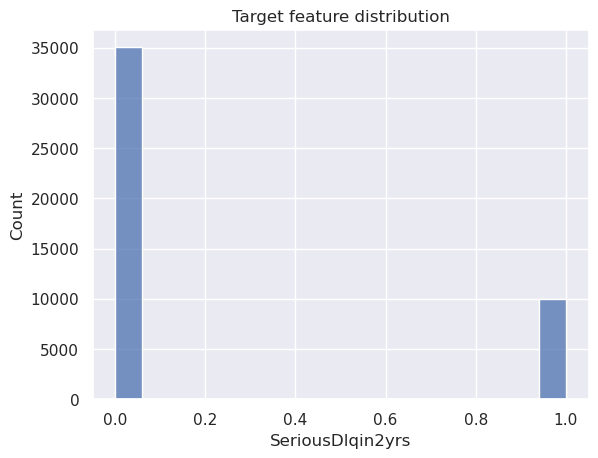

In [4]:
sns.histplot(df[target])
plt.title('Target feature distribution')
plt.savefig('../assets/Q3_hist.png')
plt.show()

In [5]:
for col in df.columns:
    df[col].fillna(df[col].median(), inplace=True)
df.head()   

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
def normalize(df):
    for feature in df.select_dtypes([int, float]).columns:
        df.loc[:, feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    return df

X = normalize(df.drop(target, axis=1))
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Bootstrapping

In [7]:
data = df['age']

n_bootstrap = 1000

original_mean = np.mean(data)

bootstrap_means = []
for _ in range(n_bootstrap):

    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    
    bootstrap_means.append(
        np.mean(bootstrap_sample)
    )

bootstrap_std = np.std(bootstrap_means)

ci_lower = np.percentile(bootstrap_means, 5)
ci_upper = np.percentile(bootstrap_means, 95)

print(f"Original mean: {original_mean:.2f}")
print(f"Bootstrap standard deviation: {bootstrap_std:.2f}")
print(f"90% bootstrap confidence interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Original mean: 51.21
Bootstrap standard deviation: 0.07
90% bootstrap confidence interval: (51.10, 51.32)


## Random Forest

In [8]:
param_grid = {
    'max_features': [1, 2, 4],  
    'min_samples_leaf': [3, 5, 7, 9],
    'max_depth': [5, 10, 15]
}

random_forest = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    class_weight='balanced'
)

grid_search = GridSearchCV(
    estimator=random_forest, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 3}


In [51]:
def plt_roc(y_true, y_score, title):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    roc_auc = roc_auc_score(y_true, y_score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

ROC AUC: 0.82


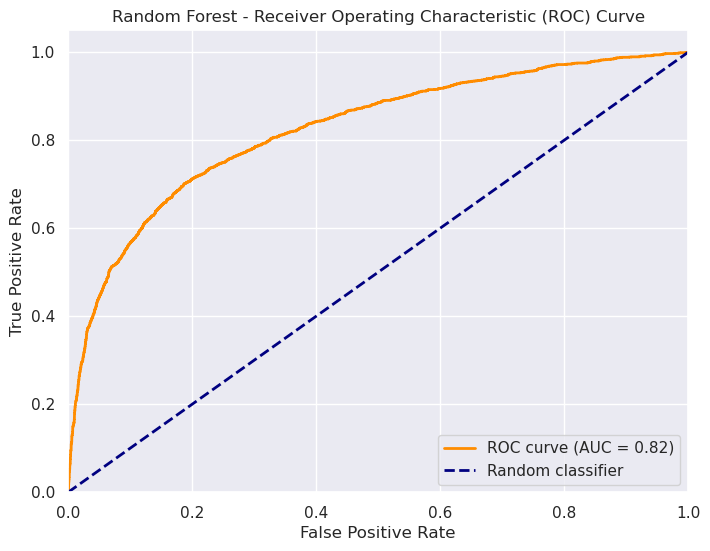

In [52]:
y_score = grid_search.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_score)

print(f"ROC AUC: {roc_auc:.2f}")


plt_roc(y_test, y_score, 'Random Forest')
plt.savefig('../assets/Q3_rf.png')
plt.show()

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
least_important_feature = X.columns[feature_importances.argmin()]
print("Least important feature: " + least_important_feature)

Least important feature: NumberOfDependents


## Bagging

In [54]:
parameters = {
    'max_features': [2, 3, 4],
    'max_samples': [0.5, 0.7, 0.9],
    'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

estimator = LogisticRegression(random_state=42)

bagging = BaggingClassifier(
    estimator=estimator,
    n_jobs=-1,
    n_estimators=100,
    random_state=42
)

grid_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=parameters,
    cv=5,
    n_iter=20
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_samples': 0.7, 'max_features': 4, 'estimator__C': 10}


ROC AUC: 0.76


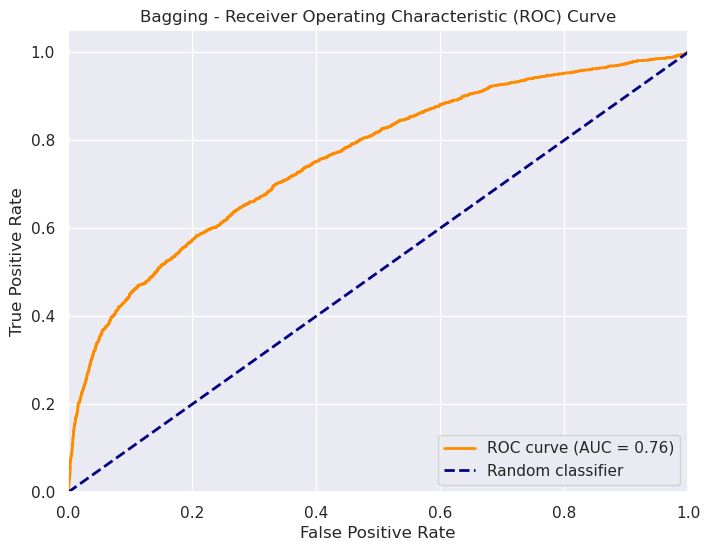

In [55]:
y_score = grid_search.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_score)

print(f"ROC AUC: {roc_auc:.2f}")


plt_roc(y_test, y_score, 'Bagging')
plt.savefig('../assets/Q3_bagging.png')
plt.show()